In [40]:
import pandas as pd
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt

In [41]:
sales_data = pd.read_csv('dataset/Project Dataset/sales_data.csv')
amount_data = pd.read_csv('dataset/Project Dataset/amount_data.csv')

In [42]:
sales_data['Date'] = pd.to_datetime(sales_data['Date'], dayfirst = True)
sales_data = sales_data.sort_values(by = 'Date')
sales_data = sales_data.reset_index().drop(columns=['index'])
sales_data

,Date,Model,Quantity
0,2022-04-01,18 F AC,0.0
1,2022-04-01,3X7NEXX,0.0
2,2022-04-01,2T5GDEL,0.0
3,2022-04-01,2T5RRLX-GX,0.0
4,2022-04-01,2T5RRLX-XX,0.0
...,...,...,...
93598,2024-04-30,40 inch LED,0.0
93599,2024-04-30,32 inch LED,0.0
93600,2024-04-30,Multiplug,0.0
93601,2024-04-30,1D4GDEH,1.0


In [43]:
amount_data['Date'] = pd.to_datetime(amount_data['Date'], dayfirst = True)
amount_data = amount_data.sort_values(by = 'Date')
amount_data = amount_data.reset_index().drop(columns=['index'])
amount_data

,Date,Amount
0,2022-04-01,0
1,2022-04-02,239400
2,2022-04-03,274140
3,2022-04-04,177000
4,2022-04-05,106000
...,...,...
756,2024-04-26,0
757,2024-04-27,582650
758,2024-04-28,367700
759,2024-04-29,451000


In [44]:
sales_data_matrix = sales_data.pivot_table(index = 'Date', columns = 'Model', values = 'Quantity', aggfunc = 'sum', fill_value = 0)
sales_data_matrix

Model,12 C AC,12 inch Fan,14 inch Fan,17 inch Fan,18 A AC,18 C AC,18 F AC,1B3GDEL,1B6GDEH,1B6GDEL,...,Room Heater,Ruti Tawa,Speaker,Stabilizer,Stand Fan,Tornedo Fan,Wall Move,Washing Machine,Water Filter,Weight Scale
Date,,,,,,,,,,,,,,,,,,,,,
2022-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-04-02,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-04-03,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-04-04,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2022-04-05,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-04-27,0.0,0.0,3.0,11.0,1.0,4.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0
2024-04-28,1.0,0.0,2.0,20.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [45]:
# Dictionary to store the predictions
predictions = {}

models = []

# Iterating over each products
for product in sales_data_matrix.columns:
    # Filtering data for the specific product
    df_model = sales_data[sales_data['Model'] == product][['Date', 'Quantity']].rename(columns={'Date': 'ds', 'Quantity': 'y'})
    
    # Initializing Prophet model
    prophet_model = Prophet()
    
    # Fiting the model
    prophet_model.fit(df_model)
    
    # Making future dataframe for predictions (e.g., next 30 days)
    future = prophet_model.make_future_dataframe(periods = 30)
    
    # Predict future quantities
    forecast = prophet_model.predict(future)
    
    # Store the predictions
    predictions[product] = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

    models.append(prophet_model)

12:51:38 - cmdstanpy - INFO - Chain [1] start processing
12:51:38 - cmdstanpy - INFO - Chain [1] done processing
12:51:39 - cmdstanpy - INFO - Chain [1] start processing
12:51:39 - cmdstanpy - INFO - Chain [1] done processing
12:51:39 - cmdstanpy - INFO - Chain [1] start processing
12:51:40 - cmdstanpy - INFO - Chain [1] done processing
12:51:40 - cmdstanpy - INFO - Chain [1] start processing
12:51:40 - cmdstanpy - INFO - Chain [1] done processing
12:51:41 - cmdstanpy - INFO - Chain [1] start processing
12:51:41 - cmdstanpy - INFO - Chain [1] done processing
12:51:41 - cmdstanpy - INFO - Chain [1] start processing
12:51:41 - cmdstanpy - INFO - Chain [1] done processing
12:51:42 - cmdstanpy - INFO - Chain [1] start processing
12:51:42 - cmdstanpy - INFO - Chain [1] done processing
12:51:42 - cmdstanpy - INFO - Chain [1] start processing
12:51:42 - cmdstanpy - INFO - Chain [1] done processing
12:51:43 - cmdstanpy - INFO - Chain [1] start processing
12:51:43 - cmdstanpy - INFO - Chain [1]

In [46]:
for i in predictions['17 inch Fan'].index:
    if predictions['17 inch Fan']['yhat'].iloc[i] < 0:
        predictions['17 inch Fan'].loc[i, "yhat"] = 0

C:\Users\CP LAB\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\CP LAB\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


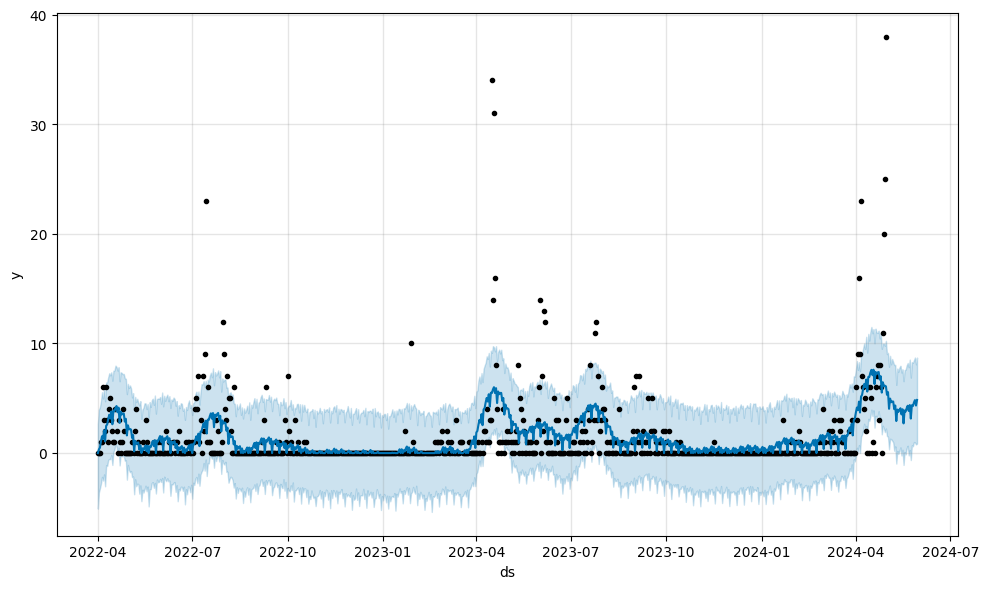

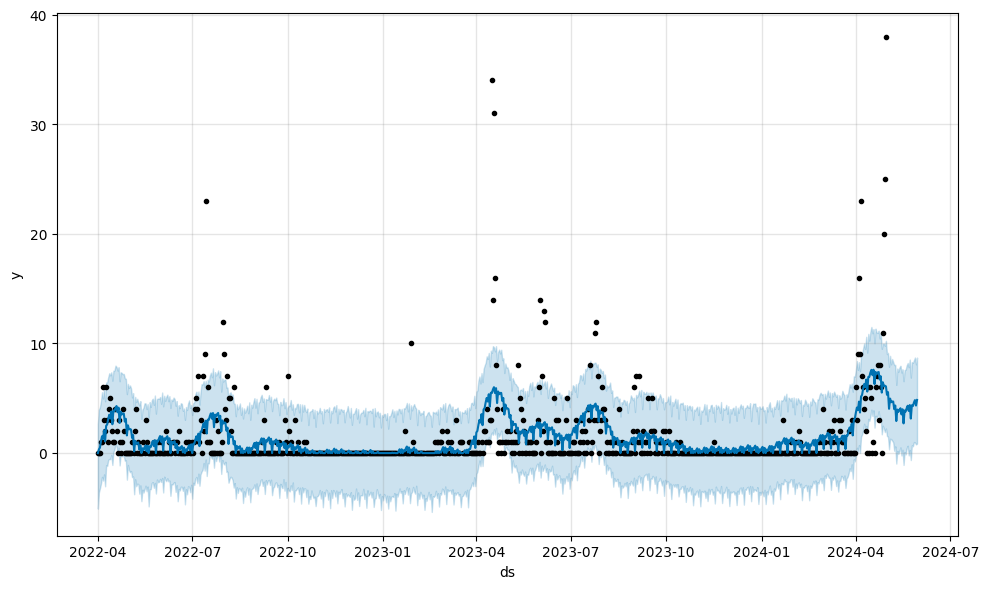

In [47]:
models[3].plot(predictions['17 inch Fan'])

In [48]:
def mean_absolute_error(y_true, y_pred):
    sum = 0
    for i in range(30):
        diff = np.abs(y_pred.iloc[i] - y_true.iloc[i])
        sum += diff
    print(sum/30)
mean_absolute_error(sales_data_matrix['17 inch Fan'].head(30), predictions['17 inch Fan']['yhat'].head(30))    

1.6986140581053724


In [49]:
y_true = sales_data_matrix['17 inch Fan']
y_pred = predictions['17 inch Fan']['yhat'].loc[:760]

In [60]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
print(mean_absolute_error(y_true, y_pred))

1.35244442331803


In [51]:
amount_data = amount_data.rename(columns={'Date': 'ds', 'Amount': 'y'})
amount_data

,ds,y
0,2022-04-01,0
1,2022-04-02,239400
2,2022-04-03,274140
3,2022-04-04,177000
4,2022-04-05,106000
...,...,...
756,2024-04-26,0
757,2024-04-27,582650
758,2024-04-28,367700
759,2024-04-29,451000


In [52]:
count = 0
holidays = []
for i in amount_data.index:
    if amount_data['y'][i] == 0:
        holidays.append(amount_data['ds'][i])
        count += 1
print(count)  
print(holidays) 

weekends = pd.DataFrame({
  'holiday': 'weekends',
  'ds': pd.to_datetime(holidays)
})

weekends

83
[Timestamp('2022-04-01 00:00:00'), Timestamp('2022-05-13 00:00:00'), Timestamp('2022-05-20 00:00:00'), Timestamp('2022-05-27 00:00:00'), Timestamp('2022-06-03 00:00:00'), Timestamp('2022-06-10 00:00:00'), Timestamp('2022-06-17 00:00:00'), Timestamp('2022-07-22 00:00:00'), Timestamp('2022-07-29 00:00:00'), Timestamp('2022-08-12 00:00:00'), Timestamp('2022-08-19 00:00:00'), Timestamp('2022-08-26 00:00:00'), Timestamp('2022-09-02 00:00:00'), Timestamp('2022-09-09 00:00:00'), Timestamp('2022-09-16 00:00:00'), Timestamp('2022-10-14 00:00:00'), Timestamp('2022-10-21 00:00:00'), Timestamp('2022-10-28 00:00:00'), Timestamp('2022-11-04 00:00:00'), Timestamp('2022-11-11 00:00:00'), Timestamp('2022-11-18 00:00:00'), Timestamp('2022-11-25 00:00:00'), Timestamp('2022-12-02 00:00:00'), Timestamp('2022-12-10 00:00:00'), Timestamp('2022-12-16 00:00:00'), Timestamp('2022-12-23 00:00:00'), Timestamp('2022-12-30 00:00:00'), Timestamp('2023-01-06 00:00:00'), Timestamp('2023-01-13 00:00:00'), Timestamp(

,holiday,ds
0,weekends,2022-04-01
1,weekends,2022-05-13
2,weekends,2022-05-20
3,weekends,2022-05-27
4,weekends,2022-06-03
...,...,...
78,weekends,2024-03-15
79,weekends,2024-04-12
80,weekends,2024-04-14
81,weekends,2024-04-19


In [53]:
m = Prophet(holidays = weekends, seasonality_mode = 'multiplicative', yearly_seasonality=50)
m.fit(amount_data)

12:52:43 - cmdstanpy - INFO - Chain [1] start processing
12:52:43 - cmdstanpy - INFO - Chain [1] done processing


In [54]:
forecast = m.predict()
amount_prediction = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

amount_prediction

,ds,yhat,yhat_lower,yhat_upper
0,2022-04-01,23253.610086,-101261.343322,155586.340507
1,2022-04-02,120720.847533,-11935.995662,252126.086322
2,2022-04-03,107844.743157,-24705.992786,249344.850787
3,2022-04-04,105226.649217,-30183.824755,229411.361052
4,2022-04-05,122240.401856,-6208.060363,251282.364029
...,...,...,...,...
756,2024-04-26,138258.078854,10092.573855,266234.875447
757,2024-04-27,316346.673219,187850.745662,458708.427749
758,2024-04-28,325970.534264,189073.481341,458423.619486
759,2024-04-29,311597.283025,179975.848825,445593.133764


In [55]:
count = 0
holidays = []
for i in amount_data.index:
    if amount_data['y'][i] == 0:
        amount_prediction.loc[i, 'yhat'] = 0
        count += 1
print(count)  
amount_prediction

83


,ds,yhat,yhat_lower,yhat_upper
0,2022-04-01,0.000000,-101261.343322,155586.340507
1,2022-04-02,120720.847533,-11935.995662,252126.086322
2,2022-04-03,107844.743157,-24705.992786,249344.850787
3,2022-04-04,105226.649217,-30183.824755,229411.361052
4,2022-04-05,122240.401856,-6208.060363,251282.364029
...,...,...,...,...
756,2024-04-26,0.000000,10092.573855,266234.875447
757,2024-04-27,316346.673219,187850.745662,458708.427749
758,2024-04-28,325970.534264,189073.481341,458423.619486
759,2024-04-29,311597.283025,179975.848825,445593.133764


In [62]:
amount_y_true = amount_data['y']
amount_y_pred = amount_prediction['yhat']

print(mean_absolute_error(amount_y_true, amount_y_pred))

64432.67716401985


C:\Users\CP LAB\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\CP LAB\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


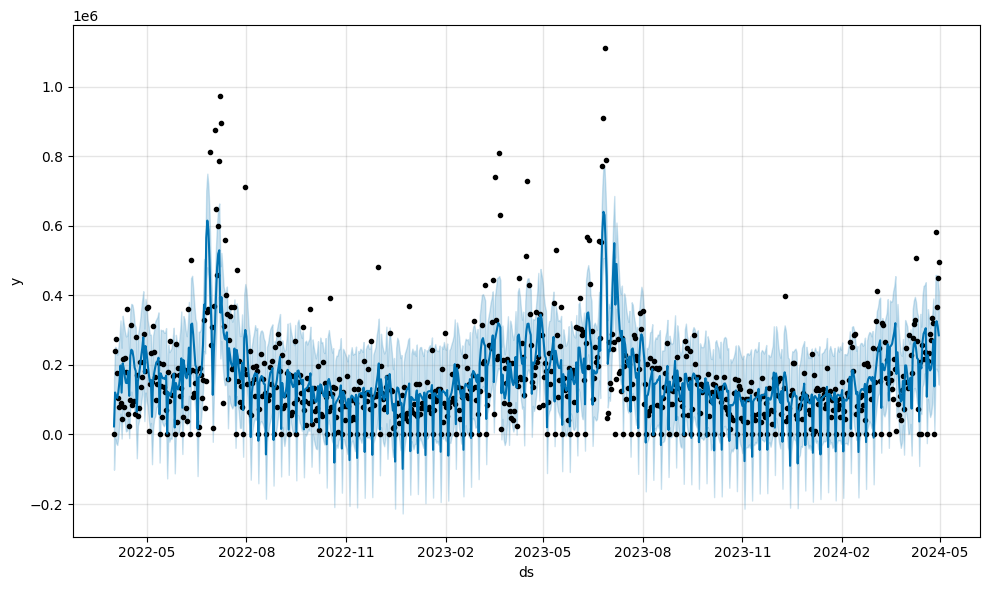

In [57]:
m.plot(forecast)
plt.show()

C:\Users\CP LAB\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\CP LAB\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\CP LAB\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0

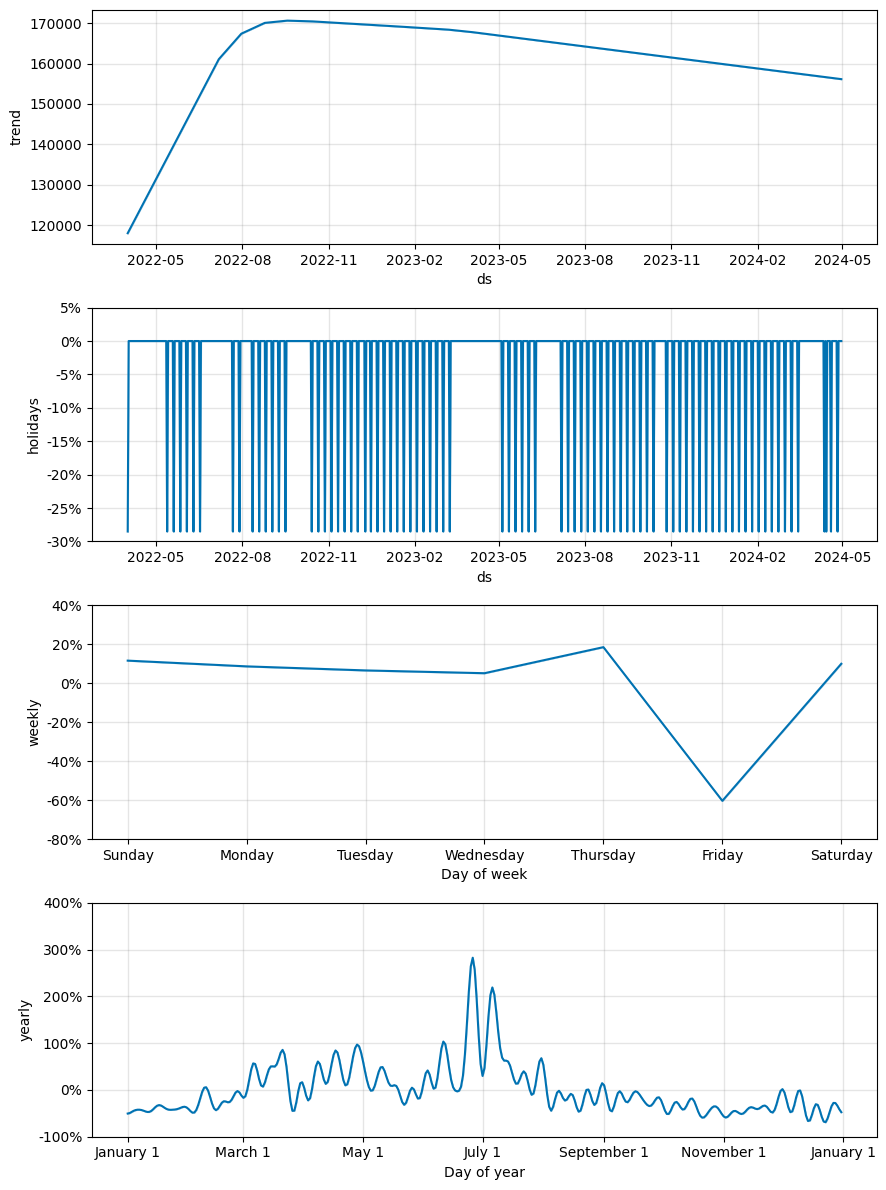

In [58]:
m.plot_components(forecast)
plt.show()